## 2 - Image Stitching
John Wu - 260612056

### 2.1 Coding Questions

#### Part I - You are given three diﬀerent views of the same scene in a folder ‘stitching images’. Follow these steps in order to stitch given images:


#### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill. 

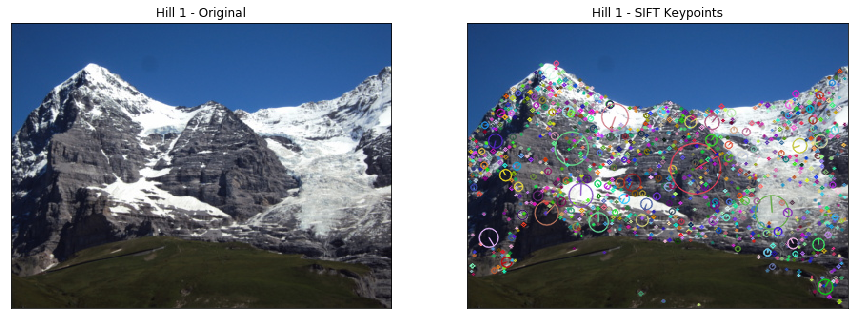

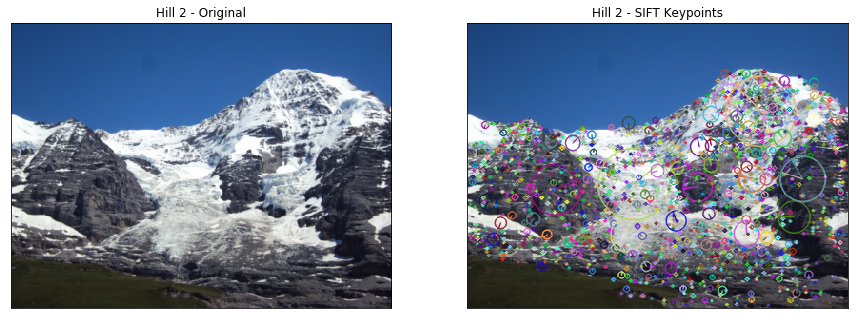

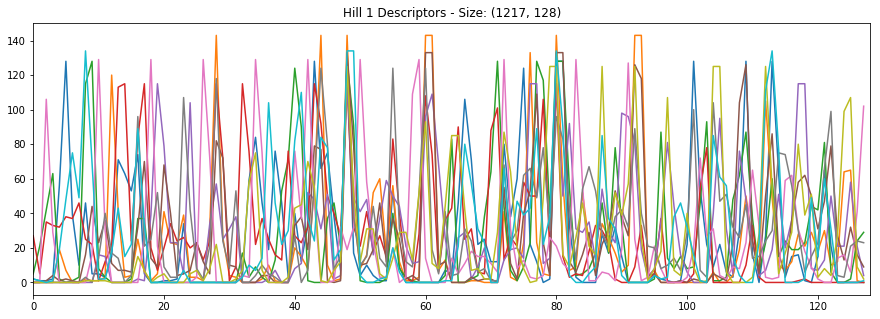

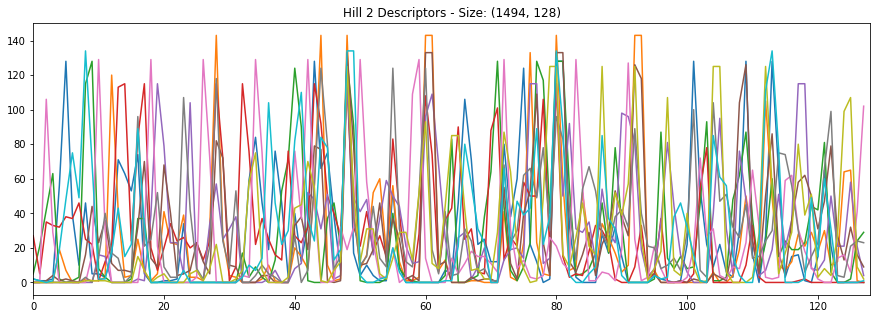

In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# read images
hill1 = cv2.imread('./stitching_images/1Hill.JPG')
hill2 = cv2.imread('./stitching_images/2Hill.JPG')
hill3 = cv2.imread('./stitching_images/3Hill.JPG')

# convert to RGB color
hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)
hill3 = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

# compute keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(hill1, None)
keypoints2, descriptors2 = sift.detectAndCompute(hill2, None)

# draw the keypoints
hill1_c = hill1.copy()
hill2_c = hill2.copy()
cv2.drawKeypoints(hill1, keypoints1, hill1_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill2, keypoints2, hill2_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display keypoints 
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill1)
plt.title("Hill 1 - Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill1_c)
plt.title("Hill 1 - SIFT Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill2)
plt.title("Hill 2 - Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_c)
plt.title("Hill 2 - SIFT Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

# display descriptors
plt.figure(figsize=(15, 5))
plt.title('Hill 1 Descriptors - Size: ' + str(descriptors1.shape))
for i in range(10):
    plt.plot(descriptors1[i])
    plt.xlim([0,128]) 
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Hill 2 Descriptors - Size: ' + str(descriptors2.shape))
for i in range(10):
    plt.plot(descriptors1[i])
    plt.xlim([0,128]) 
plt.show()

#### 2. Find matching keypoints in two images and display the 20 best pairs. 

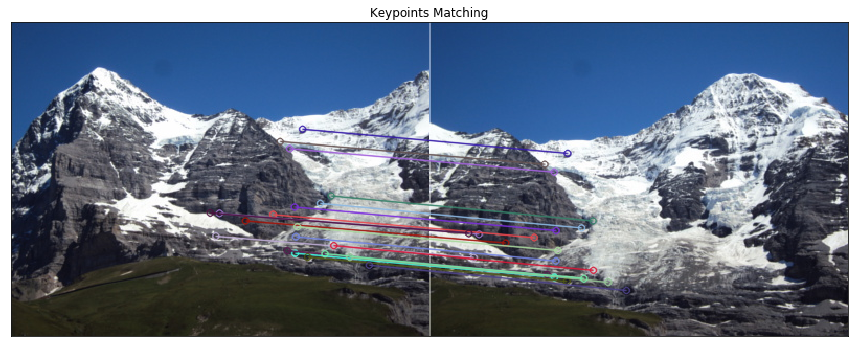

In [42]:
# match descriptors.
matches12 = cv2.BFMatcher().match(descriptors1, descriptors2)

# sort in the order of their distances
matches12 = sorted(matches12, key = lambda x:x.distance)

# draw keypoints 
img_match12 = cv2.drawMatches(hill1,keypoints1,hill2,keypoints2, matches12[:20], hill1, flags=2)

# display results
plt.figure(figsize=(15,15))
plt.imshow(img_match12)
plt.title("Keypoints Matching"), plt.xticks([]), plt.yticks([])
plt.show()

#### 3. Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

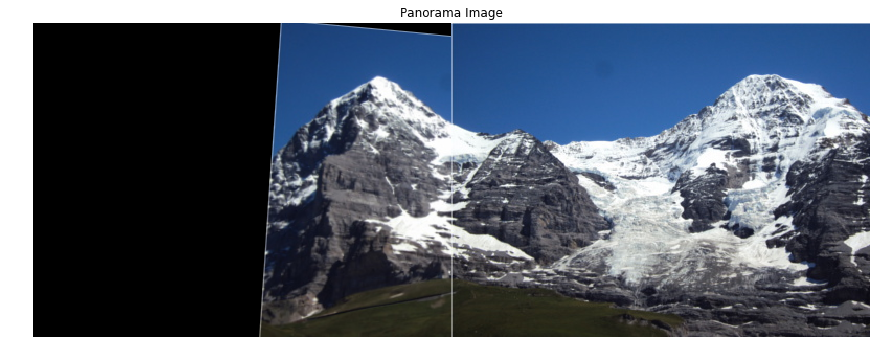

In [43]:
# arrange matching keypoints in two separate lists
good_matches12 = []
for i, m in enumerate(matches12):
    good_matches12.append((m.trainIdx, m.queryIdx))

mp1 = np.float32([keypoints2[i].pt for (i, __) in good_matches12])
mp2 = np.float32([keypoints1[i].pt for (__, i) in good_matches12])

# Get image dimensions.
h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape

# shift all the points in the right image over 
for i in range(len(mp1)):
    mp1[i][0] += w2

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp2, mp1, cv2.RANSAC, 4)

# use homography to create warped image
warped_img12 = cv2.warpPerspective(hill1, H, (w1 + w2, h2))
glued12 = warped_img12.copy()
glued12[:, w2:,:] = hill2

# display results
plt.figure(figsize=(15,15))
plt.imshow(glued12)
plt.title("Panorama Image"), plt.axis('off')
plt.show()

#### 4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

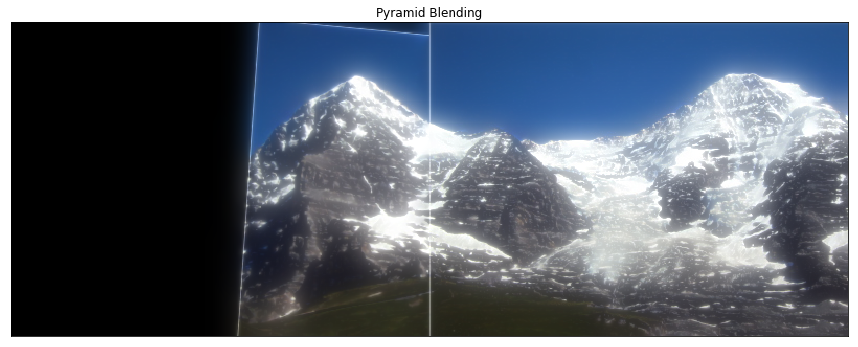

In [44]:
""" Pyramid blending """
def pyramid_blend(left, right, depth=5):
    # generate Gaussian pyramid 
    gaussian_left, gaussian_right = left.copy(), right.copy()
    gp_left, gp_right = [gaussian_left], [gaussian_right]
    for i in range(depth):
        gaussian_left = cv2.pyrDown(gaussian_left)
        gp_left.append(gaussian_left)

        gaussian_right = cv2.pyrDown(gaussian_right)
        gp_right.append(gaussian_right)

    # generate laplacian Pyramid 
    lp_left, lp_right = [gp_left[depth-1]], [gp_right[depth-1]]
    for i in range(depth-1,0,-1):
        h_left, w_left, _ = gp_left[i-1].shape
        # Make sure that the destination size matches that of gp_left[i-1].
        L = cv2.subtract(gp_left[i-1],cv2.pyrUp(gp_left[i], dstsize=(w_left, h_left)))
        lp_left.append(L)

        h_right, w_right, _ = gp_right[i-1].shape
        # Make sure that the destination size matches that of gp_right[i-1].
        L = cv2.subtract(gp_right[i-1], cv2.pyrUp(gp_right[i], dstsize=(w_right, h_right)))
        lp_right.append(L)

    # stack images together at each Laplacian Pyramid level.
    LS = []
    for la,lb in zip(lp_left,lp_right):
        ls = np.hstack((la, lb))
        LS.append(ls)

    # blend and reconstruct the final image.
    rs = LS[0]
    for i in range(1,depth):
        h, w, _ = LS[i].shape
        rs = cv2.pyrUp(rs, dstsize=(w, h))
        rs = cv2.add(rs, LS[i])
    
    return rs.astype(np.uint8)

# apply pyramid blending
hill12 = pyramid_blend(warped_img12[:,:w1], hill2)

# display results
plt.figure(figsize=(15,15))
plt.imshow(hill12)
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.show()

#### Part II - Let’s call the above resulting image 12Hill. Implement the following steps to stitch 12Hill and 3Hill.

#### 1. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

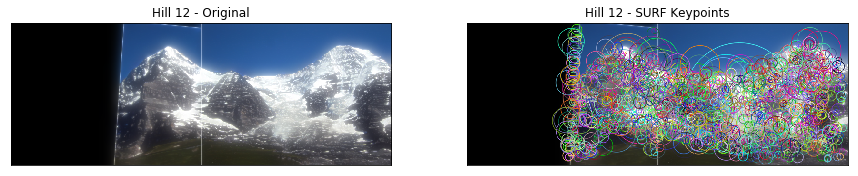

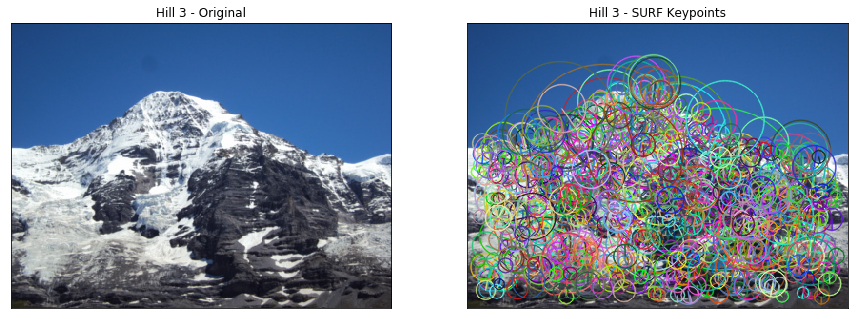

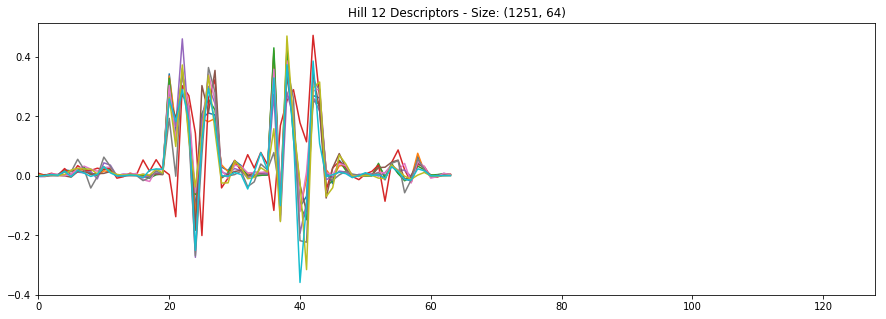

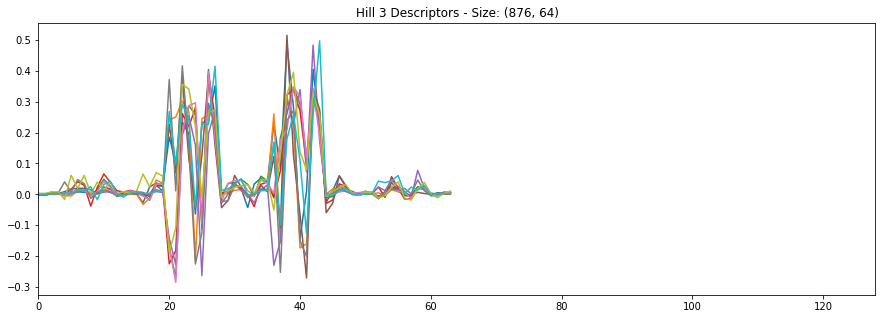

In [45]:
# compute keypoints and descriptors
surf = cv2.xfeatures2d.SURF_create()
keypoints12, descriptors12 = surf.detectAndCompute(hill12, None)
keypoints3, descriptors3 = surf.detectAndCompute(hill3, None)

# draw the keypoints
hill12_c = hill12.copy()
hill3_c = hill3.copy()
cv2.drawKeypoints(hill12, keypoints12, hill12_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill3, keypoints3, hill3_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display keypoints 
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill12)
plt.title("Hill 12 - Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill12_c)
plt.title("Hill 12 - SURF Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill3)
plt.title("Hill 3 - Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill3_c)
plt.title("Hill 3 - SURF Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

# display descriptors
plt.figure(figsize=(15, 5))
plt.title('Hill 12 Descriptors - Size: ' + str(descriptors12.shape))
for i in range(10):
    plt.plot(descriptors12[i])
    plt.xlim([0,128]) 
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Hill 3 Descriptors - Size: ' + str(descriptors3.shape))
for i in range(10):
    plt.plot(descriptors3[i])
    plt.xlim([0,128]) 
plt.show()

#### 2. Find matching keypoints in two images and display the 20 best pairs. 

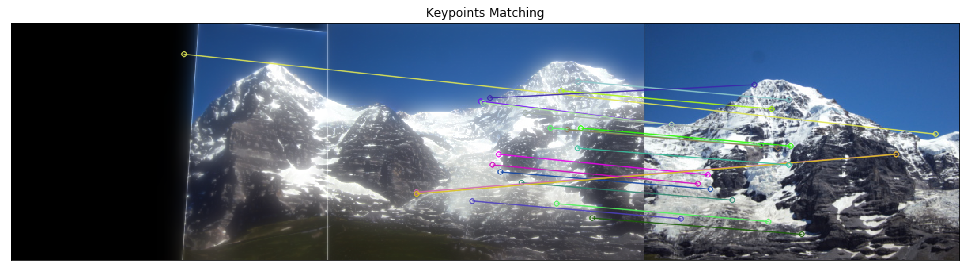

In [50]:
# match descriptors.
matches312 = cv2.BFMatcher().match(descriptors3, descriptors12)

# sort in the order of their distances
matches312 = sorted(matches312, key = lambda x:x.distance)

# draw keypoints 
img_match312 = cv2.drawMatches(hill12,keypoints12,hill3,keypoints3, matches123[:20], hill12, flags=2)

# display results
plt.figure(figsize=(17,17))
plt.imshow(img_match123)
plt.title("Keypoints Matching"), plt.xticks([]), plt.yticks([])
plt.show()

#### 3. Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

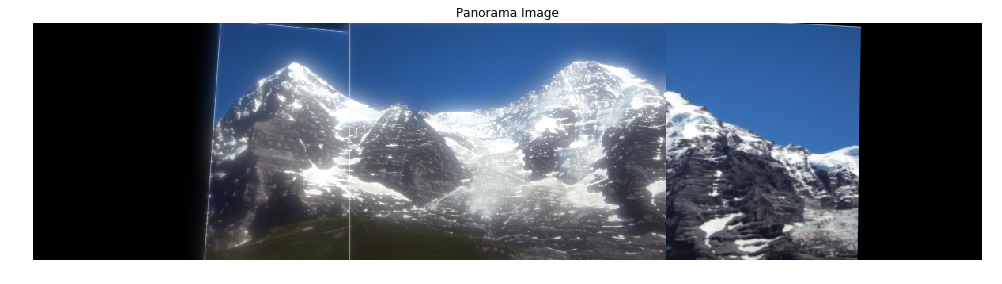

In [53]:
# arrange matching keypoints in two separate lists
good_matches312 = []
for i, m in enumerate(matches312):
    good_matches312.append((m.trainIdx, m.queryIdx))

mp12 = np.float32([keypoints12[i].pt for (i, __) in good_matches312])
mp3 = np.float32([keypoints3[i].pt for (__, i) in good_matches312])

# Get image dimensions.
h12, w12, _ = hill12.shape
h3, w3, _ = hill3.shape

# shift all the points in the left image over 
for i in range(len(mp3)):
    mp3[i][0] += w12 + w3

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp12, mp3, cv2.RANSAC, 4)

# use homography to create warped image
warped_img3 = cv2.warpPerspective(hill3, H, (w1 + w2 + w3, h2))
glued312 = warped_img3.copy()
glued312[:, :w12,:] = hill12

# display results
plt.figure(figsize=(17,17))
plt.imshow(glued312)
plt.title("Panorama Image"), plt.axis('off')
plt.show()

#### 4. Stitch transformed 3Hill and 12Hill together and apply linear image blending.

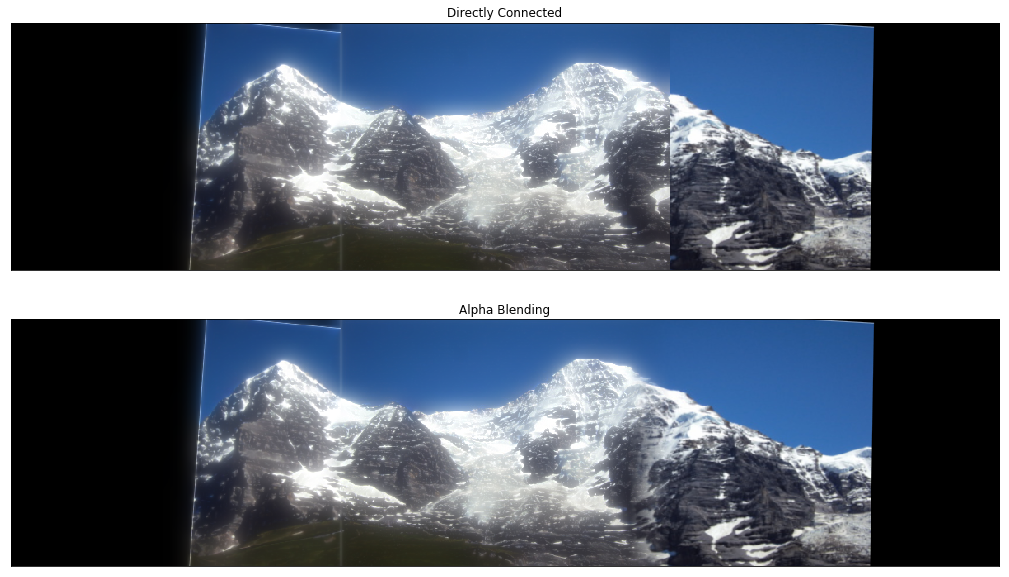

In [48]:
""" Alpha blending """
def alpha_blend(image_width, ramp_width, ramp_index):
    start, end = 0, 1
    res = np.zeros((image_width)).astype(np.float)
    step = (end - start) / (ramp_width - 1)
    index = ramp_index - (ramp_width)
    for i in range(ramp_width):
        res[index] = start + step * i
        index += 1
    res[index:] = 1
    return res

# read images
img1 = np.zeros((h12, w12 + w3, 3)).astype(np.uint8)
img1[:,:w12,:] = hill12
img2 = warped_img3

# image with direct connecting each half
real = np.hstack((img1[:,:w12,:], img2[:,w12:,:])).astype(np.uint8)

# alpha blending ramp
alpha = alpha_blend(img1.shape[1], 50, w12)

# apply feathering and blend
I_blend = (1 - alpha.reshape(1,-1,1)) * img1 + alpha.reshape(1,-1,1) * img2
I_blend = np.uint8(I_blend)  

# display result
plt.figure(figsize=(25,10))
plt.subplot(211), plt.imshow(real)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2 - Reasoning Questions

#### 1. What are the diﬀerences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics. 

SIFT includes both a detector and a descriptor. The detecotr is based on the difference of gaussians, an approximation of the Laplacian, which detects centers of blob-like structures. Meanwhile, SURF includes a descriptor that is based on a histogram of gradient orientations. SURF is meant to be a fast approximation of SIFT and hence works about 3-6 times faster. As a tradeoff to speed, SURF is less robust to changes in illumination, which is reflected by the density and number of keypoints detected for a given image. This is proven in the example below.

In [49]:
# quick test to see difference in results
sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
sift_points, _ = sift.detectAndCompute(hill1, None)
surf_points, _ = surf.detectAndCompute(hill1, None)
print("Number of points using SIFT: " + str(len(sift_points)))
print("Number of points using SURF: " + str(len(surf_points)))

Number of points using SIFT: 1217
Number of points using SURF: 891


#### 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending? 

Pyramid Blending: 
Pros - It adjusts to different frequencies by blending at different speeds. It also creates a balance between smoothing low frequency exposure variations, while preserving sharp transitions.
Cons - It is requires much heavier computation. As a result, it is also slower and harder to implement.

Linear Blending: 
Pros - It is easier to implement due to its lighter computation.
Cons - It does not retain any sharp transitions and is not as smooth, due to its inability to adjust to different frequencies as well.

If the image is not as smooth and has many changing frequencies, then linear blending should be used for simplicity. Otherwise pyramid blending will be needed.

#### 3. What would happen if a random subset of pairs of matching keypoints is used for ﬁnding homography? 

If we used a random subset of pairs of matching keypoints, then we would get a less accurate result for the global displacement vector. This would continue to give a bad transformation that would ultimately result in a less than optimal stitching.

#### 4. Discuss the relationship between the number of pairs of matching keypoints used for ﬁnding homography and the accuracy of inferred homography. 

The number of pairs of matching keypoints does not determine the accuracy of the inferred homography. Its accuracy depends the number of inliers, or more precisely, the number of correctly projected points. As a result, having lots of matches with many outliers can potentially give an less accurate result than have very few matches with many inliers.